In [1]:
import os
import sys
sys.path.append('../../')
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.title_fontsize' : 7,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from theory_simulation.effective_dimensionality import EDSimulation

In [2]:
# Base simulation
if os.path.exists('data/base_simulations.csv'):
    data_base = pd.read_csv('data/base_simulations.csv')
else:
    sim = EDSimulation(ambient=30)
    sim.make_nat_manifold(ed=20)
    sim.make_eco_manifold(ed=10, alignment='nat', alignment_strength=0.5)
    sim.make_data_manifold(ed=30)

    data_base = []
    n_repeats = 50

    for model_ed in tqdm(np.logspace(np.log10(1.01), np.log10(30), num=20)):
        sim.make_model_manifold(ed=model_ed, alignment='nat', alignment_strength=0.5)

        for _ in range(n_repeats):
            sim.sample()
            data_base.append(sim.encoding_performance())

    data_base = pd.DataFrame(data_base)
    data_base.to_csv('data/base_simulations.csv', index=False)

# Counterexamples simulation
if os.path.exists('data/counterexamples_simulations.csv'):
    data_counter = pd.read_csv('data/counterexamples_simulations.csv')
else:
    sim = EDSimulation(ambient=100)
    sim.make_nat_manifold(ed=100)
    sim.make_eco_manifold(ed=2)
    sim.make_data_manifold(ed=100)

    data_counter = []
    n_repeats = 50

    model_ed_range = (3, 5)
    for _ in tqdm(range(n_repeats)):
        model_ed = np.random.uniform(*model_ed_range)
        sim.make_model_manifold(ed=model_ed, alignment='eco', alignment_strength=1)
        sim.sample()
        sample = sim.encoding_performance()
        sample['alignment'] = 'high'
        data_counter.append(sample)

    model_ed_range = (15, 20)
    for _ in tqdm(range(n_repeats)):
        model_ed = np.random.uniform(*model_ed_range)
        sim.make_model_manifold(ed=model_ed, alignment='eco', alignment_strength=-1)
        sim.sample()
        sample = sim.encoding_performance()
        sample['alignment'] = 'low'
        data_counter.append(sample)

    data_counter = pd.DataFrame(data_counter)
    data_counter.to_csv('data/counterexamples_simulations.csv', index=False)

---
# Effect of model ED

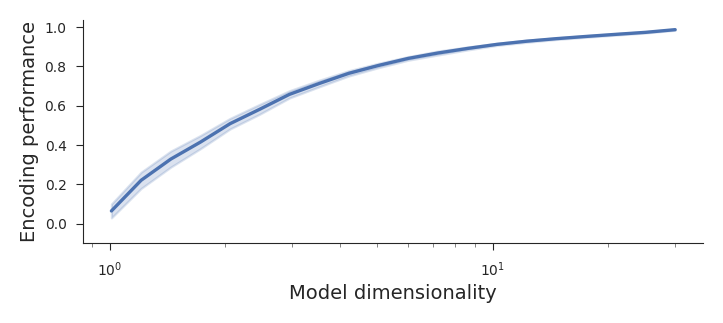

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 1.5))

# ax.axvline(10, linestyle='--', color='black', alpha=0.3)
sns.lineplot(data=data_base, x='model_ed', y='r2_ceiled',
             ci='sd', ax=ax)

ax.set(xlabel='Model dimensionality', ylabel=r'Encoding performance', ylim=(-0.1, None), xscale='log')
# ax.text(.33, .4, r'$ED_{ecological} = 10$', transform=ax.transAxes)

plt.savefig('saved/simulations_base.png', dpi=500)
plt.show()

---
# Counter example

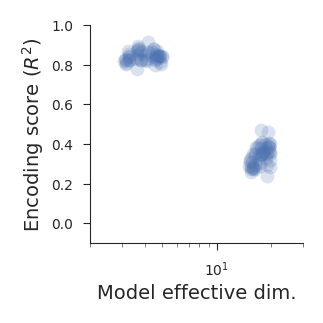

In [17]:
fig, ax = plt.subplots(figsize=(1.5, 1.5))

sns.scatterplot(data=data_counter, x='model_ed', y='r2_ceiled', 
                linewidth=0, s=25, alpha=0.2, ax=ax)

ax.set(xlabel='Model effective dim.', ylabel=r'Encoding score ($R^2$)', ylim=(-0.1, 1), xlim=(2, 30), xscale='log')

plt.savefig('saved/simulations_counterexample.png', dpi=500)
plt.show()